# Compute event waveform stacks using the most similar events found by CC detection

In [42]:
# Import modules

from matplotlib.pyplot import subplots
from matplotlib import ticker
from obspy import read, UTCDateTime
from utils_basic import ROOTDIR, DELTA
from utils_snuffler import read_normal_markers
from utils_preproc import read_and_process_template_waveforms, read_and_process_match_waveforms
from utils_spec import get_data_spectrum, get_filter_response
from utils_cc import read_template_and_match, get_timewin_from_template_name, get_freqband_from_suffix
from pandas import DataFrame
from os.path import join
from numpy import amax, argmax, abs, zeros
from re import search

In [43]:
# Inputs
tempname = "BeatA12-17-00-57"
suffix = "bandpass10-450hz_dur0.10s_mincc0.7_mindet4"
rootdir = ROOTDIR
stations_add = ["A09", "A10", "A11"]

numsta_min = 6
avgcc_min = 0.9

begin = -0.05
end = 0.25

linewidth_indiv = 0.5
linewidth_stack = 2

In [44]:
# Read the template and match information

## Extract the time window of the template
timewin = get_timewin_from_template_name(tempname)

## Read the file
inpath = join(rootdir, timewin, f"ccmatches_{tempname}_{suffix}.dat")
template_and_match = read_template_and_match(inpath)
template = template_and_match.template
stations_temp = template.stations


In [45]:
# Extract the matches that meet the criteria
matches = template_and_match.matches
print(f"Number of matches in total: {len(matches)}")

matches = matches.get_matches_by_criteria(avgcc_min, numsta_min)
print(f"Number of matches satisfying the criteria: {len(matches)}")

Number of matches in total: 3252
Number of matches satisfying the criteria: 36


In [46]:
# Read and process the template waveforms
freqmin, freqmax = get_freqband_from_suffix(suffix)
template_waveforms = read_and_process_template_waveforms(template, freqmin, freqmax, stations=stations_temp, begin=begin, end=end, reference="common")

In [47]:
# Read and process the match waveforms
match_waveforms = read_and_process_match_waveforms(matches, freqmin, freqmax, stations=stations_temp, begin=begin, end=end, reference="common")

Processed 1 of 36 matches!
Processed 2 of 36 matches!
Processed 3 of 36 matches!
Processed 4 of 36 matches!
Processed 5 of 36 matches!
Processed 6 of 36 matches!
Processed 7 of 36 matches!
Processed 8 of 36 matches!
Processed 9 of 36 matches!
Processed 10 of 36 matches!
Processed 11 of 36 matches!
Processed 12 of 36 matches!
Processed 13 of 36 matches!
Processed 14 of 36 matches!
Processed 15 of 36 matches!
Processed 16 of 36 matches!
Processed 17 of 36 matches!
Processed 18 of 36 matches!
Processed 19 of 36 matches!
Processed 20 of 36 matches!
Processed 21 of 36 matches!
Processed 22 of 36 matches!
Processed 23 of 36 matches!
Processed 24 of 36 matches!
Processed 25 of 36 matches!
Processed 26 of 36 matches!
Processed 27 of 36 matches!
Processed 28 of 36 matches!
Processed 29 of 36 matches!
Processed 30 of 36 matches!
Processed 31 of 36 matches!
Processed 32 of 36 matches!
Processed 33 of 36 matches!
Processed 34 of 36 matches!
Processed 35 of 36 matches!
Processed 36 of 36 matches!
I

In [48]:
# Compute the waveform stacks
wfdict = {}
stackdict = {}

dt = DELTA
numpts = int((end - begin) / dt) + 1

for station in stations_temp:
    for component in ["Z", "1", "2"]:
        ## Initialize the stack
        stack = zeros(numpts)
        datmat = zeros((numpts, len(match_waveforms)+1))
        count = 1

        ## Get the template waveform
        trace = template_waveforms.waveforms.select(station=station, component=component)[0]
        data = trace.data
        datmat[:, 0] = data / amax(data)

        ## Get the match waveforms
        for match in match_waveforms:
            if station in match.info.stations:
                trace = match.waveforms.select(station=station, component=component)[0]
                data = trace.data
                datmat[:, count] = data / amax(data)
                count += 1

        ## Compute the stack
        stack = datmat.mean(axis=1)

        ## Store the stack
        wfdict[(station, component)] = datmat
        stackdict[(station, component)] = stack
        


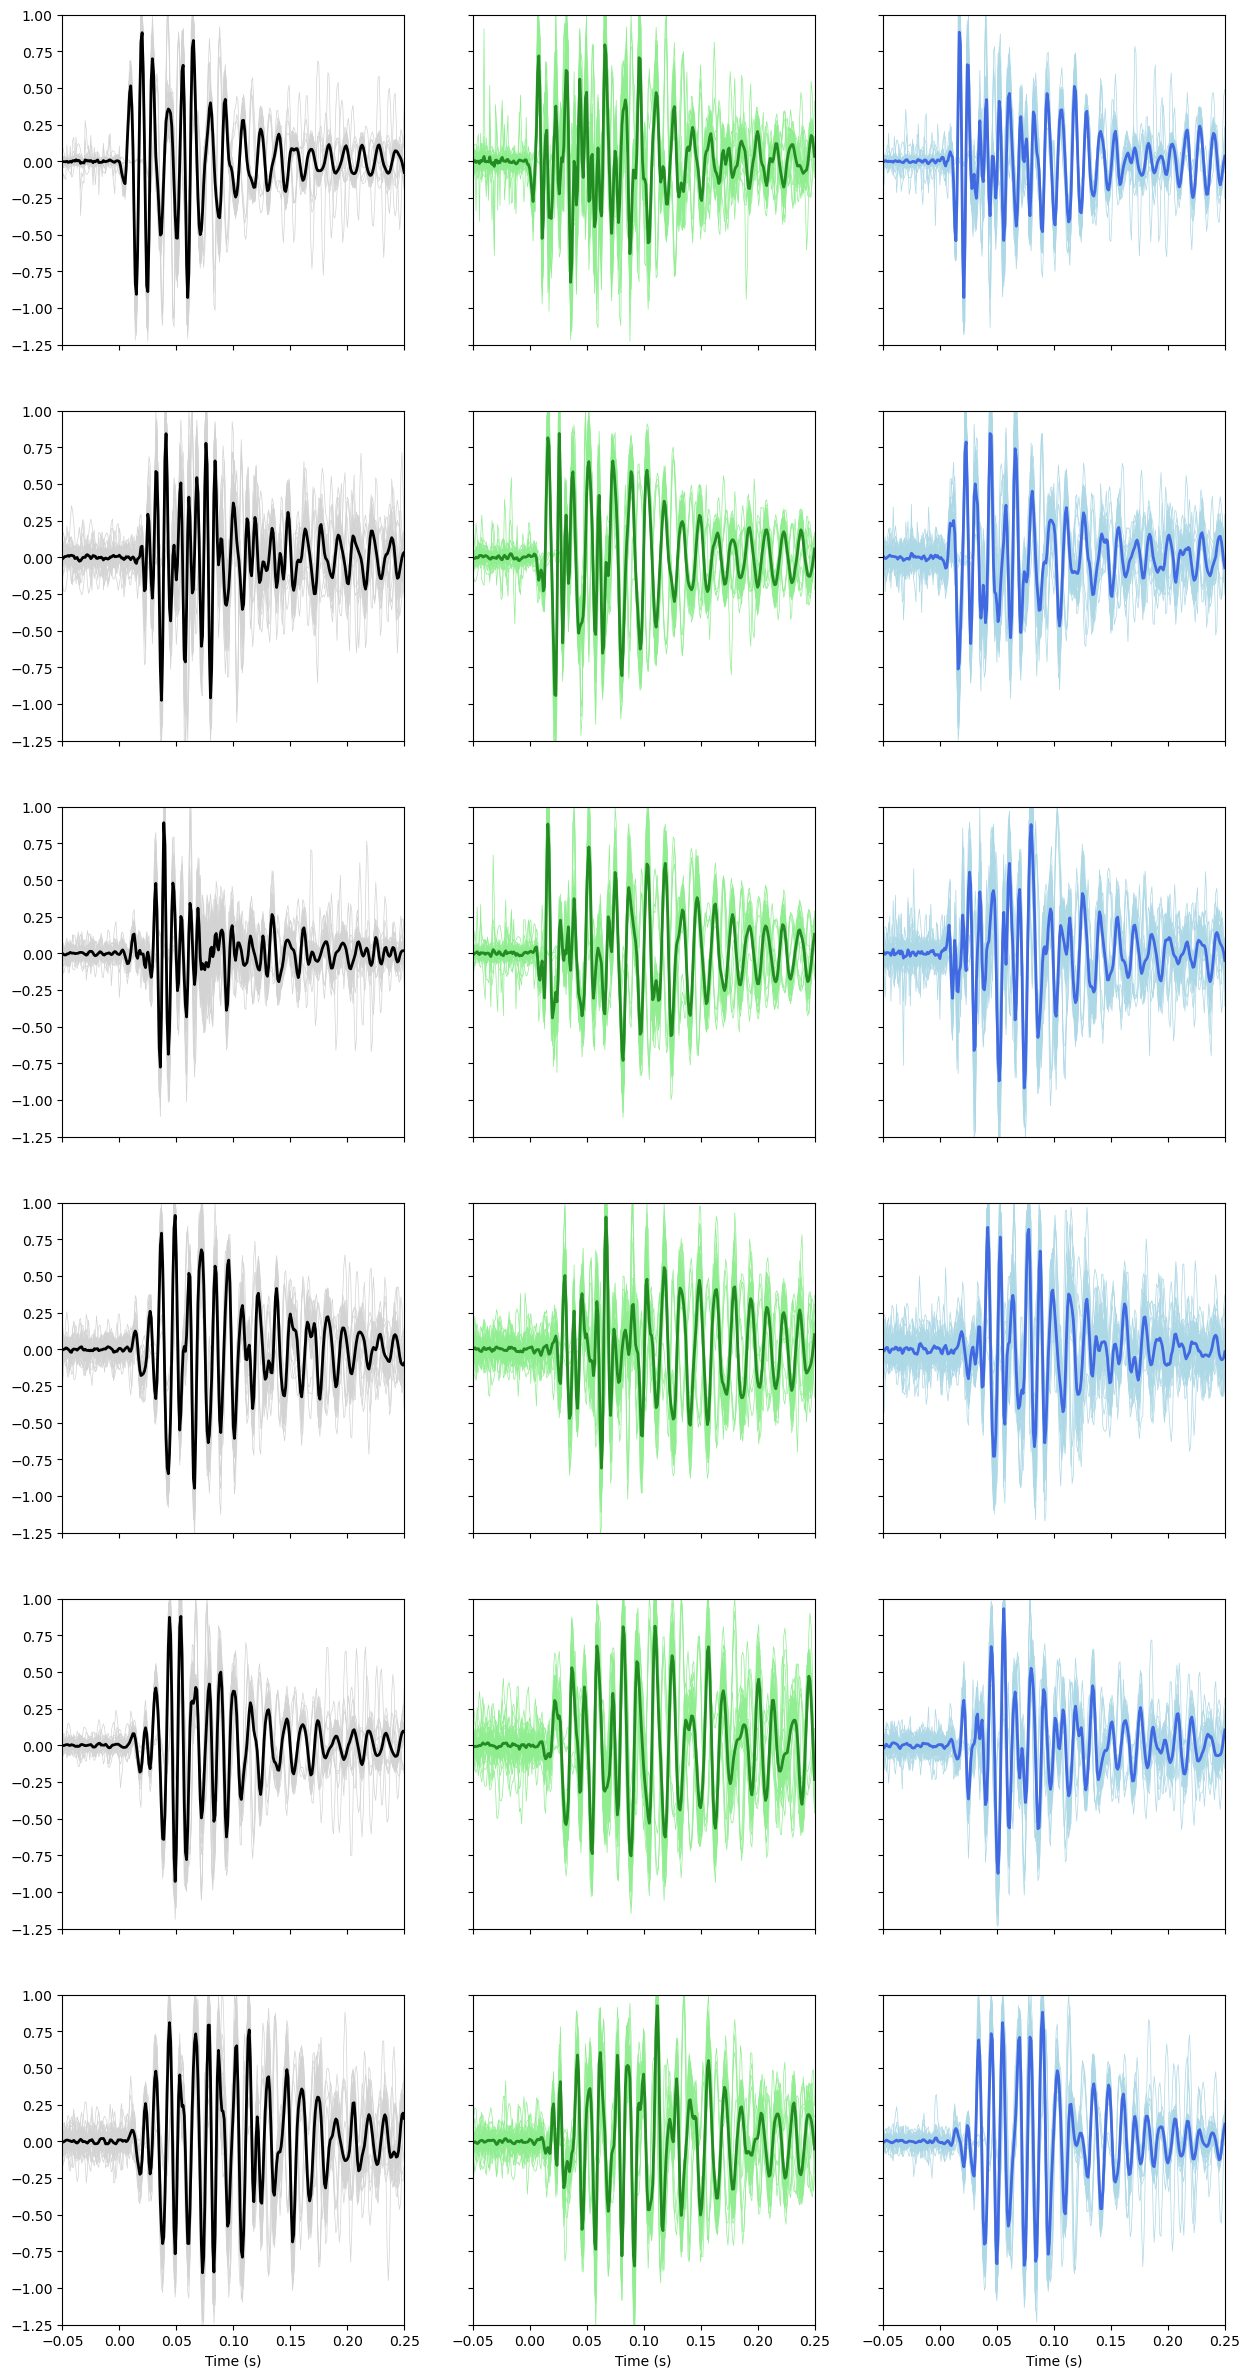

In [49]:
# Plot the stacks and the contributing waveforms
fig, axes = subplots(nrows=len(stations_temp), ncols=3, figsize=(15, 5*len(stations_temp)), sharex=True, sharey=True)

for i, station in enumerate(stations_temp):
    for j, component in enumerate(["Z", "1", "2"]):
        ax = axes[i, j]
        trace = template_waveforms.waveforms.select(station=station, component=component)[0]
        timeax = trace.times() + begin

        ## Plot the contributing waveforms
        datmat = wfdict[(station, component)]

        if component == "Z":
            ax.plot(timeax, datmat, color="lightgray", linewidth=linewidth_indiv)
        elif component == "1":
            ax.plot(timeax, datmat, color="lightgreen", linewidth=linewidth_indiv)
        elif component == "2":
            ax.plot(timeax, datmat, color="lightblue", linewidth=linewidth_indiv)

        ## Plot the stack
        stack = stackdict[(station, component)]

        if component == "Z":
            ax.plot(timeax, stack, "black", linewidth=linewidth_stack)
        elif component == "1":
            ax.plot(timeax, stack, "forestgreen", linewidth=linewidth_stack)
        elif component == "2":
            ax.plot(timeax, stack, "royalblue", linewidth=linewidth_stack)

        ## Set the labels
        ax.set_xlim(begin, end)
        ax.set_ylim(-1.25, 1)

        if i == len(stations_temp) - 1:
            ax.set_xlabel("Time (s)")